# Load Documents from a directory

In [1]:
import os
import time

In [2]:
import sys
sys.executable

'/Users/cherifbenham/.pyenv/versions/3.11.5/bin/python3.11'

In [6]:
directory_path='data/'

In [3]:
%%time

from langchain.document_loaders import PyPDFLoader

def load_documents(directory_path):    
    pdf_files = [f for f in os.listdir(directory_path) if f.endswith('.pdf')]
    documents = []
    for pdf_file in pdf_files:
        pdf_path = os.path.join(directory_path, pdf_file)
        loader = PyPDFLoader(pdf_path)
        documents.extend(loader.load())
    return documents

CPU times: user 528 ms, sys: 1.11 s, total: 1.64 s
Wall time: 473 ms


In [9]:
documents = load_documents(directory_path)
print('number of documents ' + str(len(documents)))

number of documents 117


# Pre-process the data

In [11]:
import re

def preprocess_content(text):
    # Remove non-breaking spaces
    text = text.replace('\xa0', ' ')
    # Remove newline characters
    text = text.replace('\n', ' ')
    # Correct multiple spaces
    text = re.sub(' +', ' ', text)
    # Add line breaks before titles or subtitles
    text = re.sub(r'(?<=[a-z])([A-Z][a-z]+)', r'\n\1', text)
    # Removing digits followed by 'TS' which seems to be a page reference or figure number
    text = re.sub(r'\d+TS', '', text)
    # Remove references like {2.2}
    text = re.sub(r'\{\d+(\.\d+)?\}', '', text)
    # Remove content within curly braces
    content = re.sub(r'\{.*?\}', '', text)
    # Replace newline characters and multiple spaces with a single space
    content = re.sub(r'\s+', ' ', text)
    # Trim leading and trailing spaces
    content = content.strip()
    return content

# Test
doc_content = documents[10]
preprocessed_content = preprocess_content(documents[10].page_content)
print(preprocessed_content)

11SPM Summary for Policymakers B.1.4 Climate change has adversely affected physical health of people globally (very high confidence) and mental health of people in the assessed regions (very high confidence). Climate change impacts on health are mediated through natural and human systems, including economic and social conditions and disruptions (high confidence). In all regions extreme heat events have resulted in human mortality and morbidity (very high confidence). The occurrence of climate-related food-borne and water-borne diseases has increased (very high confidence). The incidence of vector-borne diseases has increased from range expansion and/or increased reproduction of disease vectors (high confidence). Animal and human diseases, including zoonoses, are emerging in new areas (high confidence). Water and food-borne disease risks have increased regionally from climate-sensitive aquatic pathogens, including Vibrio spp. ( high confidence), and from toxic substances from harmful fr

# Create an enriched version of the Class

In [12]:
# We will add some metadata to class Document
class Document:
    def __init__(self, page_content, metadata):
        self.page_content = page_content
        self.metadata = metadata

class EnrichedDocument(Document):
    def __init__(self, page_content, metadata):
        super().__init__(page_content, metadata)

# Split Documents into Smaller chunks

In [13]:
import tiktoken

def num_tokens_from_string(string, encoding_name):
    """Returns the number of tokens in a text string."""
    encoding_name = "cl100k_base"
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_documents_into_chunks(directory_path, text_splitter):
    
    documents = load_documents(directory_path)
        
    all_enriched_documents = []
    global_page_number = 0
    chunk_id = 0
    
    for doc in documents:
        chunks = text_splitter.split_text(doc.page_content)
        
        for chunk in chunks:
            char_count = len(chunk)
            token_count = num_tokens_from_string(chunk,"cl100k_base")
            
            enriched_metadata = {
                'source': doc.metadata['source'],
                'path': doc.metadata.get('path', ''),  # Assuming 'path' might be optional in original metadata
                'page': doc.metadata['page'],
                'char_count': char_count,
                'token_count': token_count,
                'global_page_number': global_page_number,
                'chunk_id': chunk_id
            }
            
            enriched_doc = EnrichedDocument(chunk, enriched_metadata)
            
            all_enriched_documents.append(enriched_doc)
            chunk_id += 1
        
        global_page_number += 1  # Increment the global page number for each document

    return all_enriched_documents

chunk_size=500
chunk_overlap=0
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
enriched_documents = split_documents_into_chunks(directory_path, text_splitter)

In [15]:
print(enriched_documents[40].page_content)  # Print the first enriched document

Figure SPM.1 | This report has a strong focus on the interactions among the coupled systems climate, ecosystems (including their biodiversity) and human society. These interactions are the basis of emerging risks 
from climate change, ecosystem degradation and biodiversity loss and, at the same time, offer opportunities for the future.


In [16]:
len(enriched_documents)

1209

In [17]:
enriched_documents[40].metadata

{'source': 'data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf',
 'path': '',
 'page': 5,
 'char_count': 337,
 'token_count': 63,
 'global_page_number': 5,
 'chunk_id': 40}

## Reprocess the data

In [18]:
# Applying preprocessing
for doc in enriched_documents:
    doc.page_content = preprocess_content(doc.page_content)

# Now, each document's page_content attribute is preprocessed

# Create a dataframe out of the enriched documents

In [19]:
import pandas as pd

def enriched_docs_to_dataframe(enriched_documents):
    # Extract the content and metadata into separate lists
    contents = [doc.page_content for doc in enriched_documents]
    metadata_list = [doc.metadata for doc in enriched_documents]
    
    # Convert metadata list to DataFrame
    df = pd.DataFrame(metadata_list)
    
    # Add content to DataFrame
    df['page_content'] = contents
    
    return df

# Usage:
df_enriched_docs = enriched_docs_to_dataframe(enriched_documents)
df_enriched_docs.head()  # Print the first few rows of the DataFrame


,source,path,page,char_count,token_count,global_page_number,chunk_id,page_content
0,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,0,26,7,0,0,Summary for Policymakers
1,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,2,492,144,2,1,SPM3 Summary for Policymakers Drafting Authors...
2,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,2,452,131,2,2,"Andrew Constable (Australia), Wolfgang Cramer ..."
3,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,2,453,133,2,3,"Wolfgang Kiessling (Germany), Rodel Lasco (Phi..."
4,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,2,468,145,2,4,"Mariana Moncassim Vale (Brazil), Mike D Morecr..."


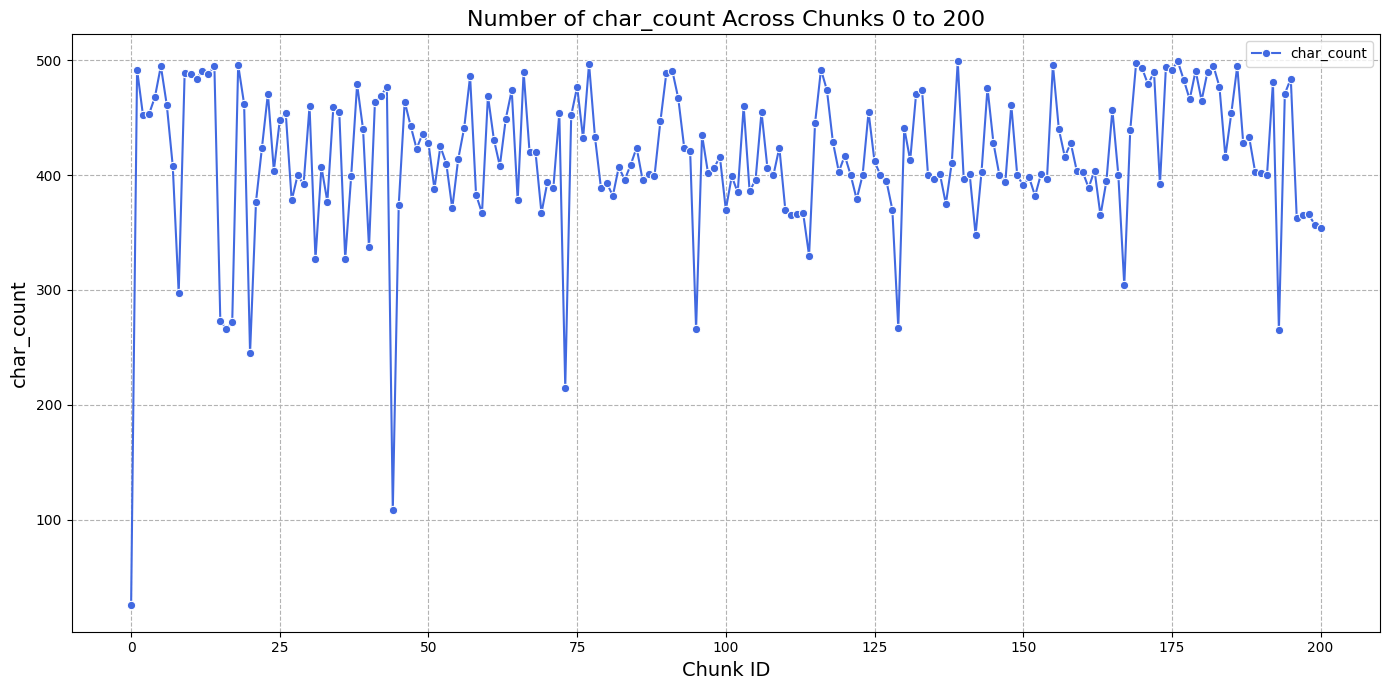

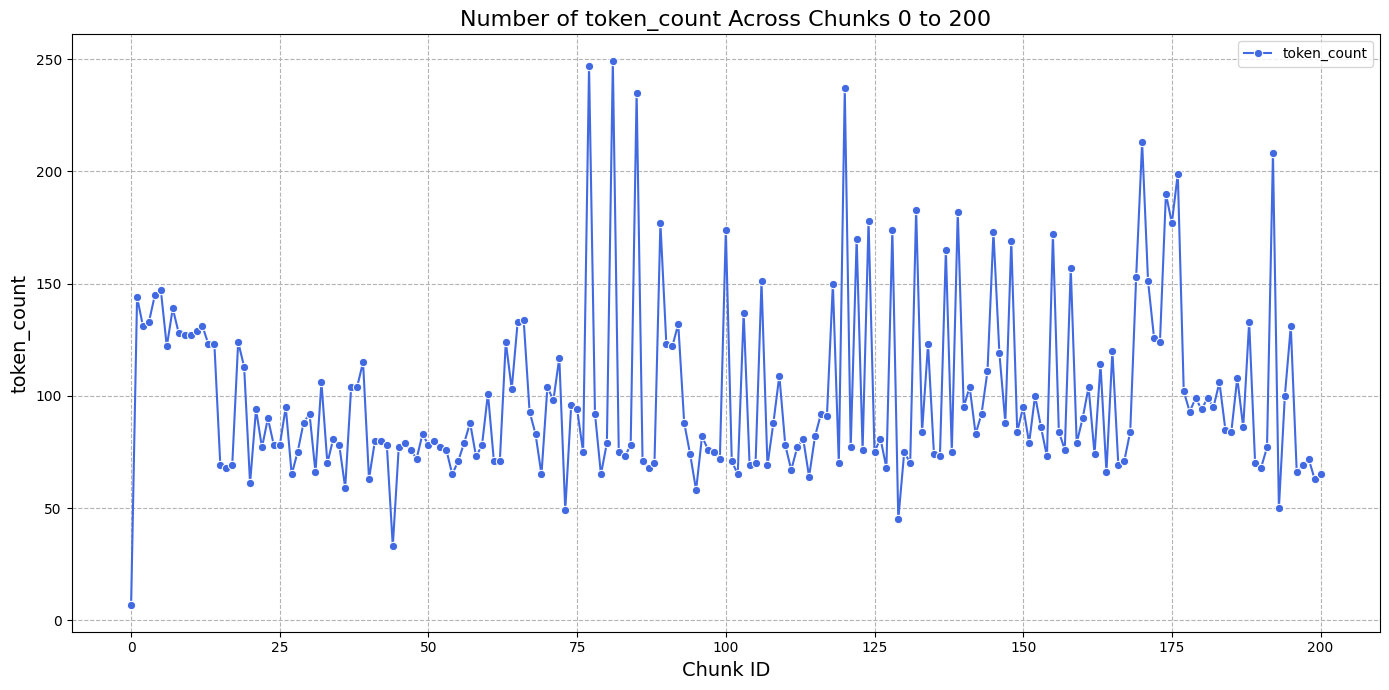

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_across_chunks(df, column_name, start_chunk=0, end_chunk=200):

    # Filter the dataframe to only include the specified range of chunks
    df_filtered = df[(df['chunk_id'] >= start_chunk) & (df['chunk_id'] <= end_chunk)]
    
    # Setting up the figure and axis
    plt.figure(figsize=(14, 7))
    
    # Plotting number of characters across chunks
    sns.lineplot(data=df_filtered, x='chunk_id', y=str(column_name), marker="o", color='royalblue', label=column_name)
    
    # Beautifying the plot
    plt.title(f'Number of {column_name} Across Chunks {start_chunk} to {end_chunk}', fontsize=16)
    plt.xlabel('Chunk ID', fontsize=14)
    plt.ylabel(column_name, fontsize=14)
    plt.legend()
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()

    # Display the plot
    plt.show()

# Usage:
plot_across_chunks(df_enriched_docs, 'char_count', start_chunk=0, end_chunk=200)
plot_across_chunks(df_enriched_docs, 'token_count', start_chunk=0, end_chunk=200)

## Distribution of char count and token count

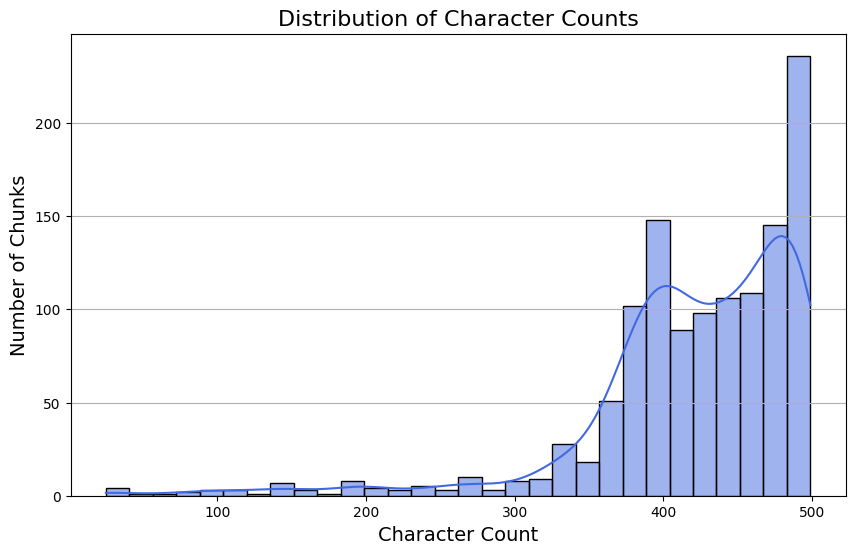

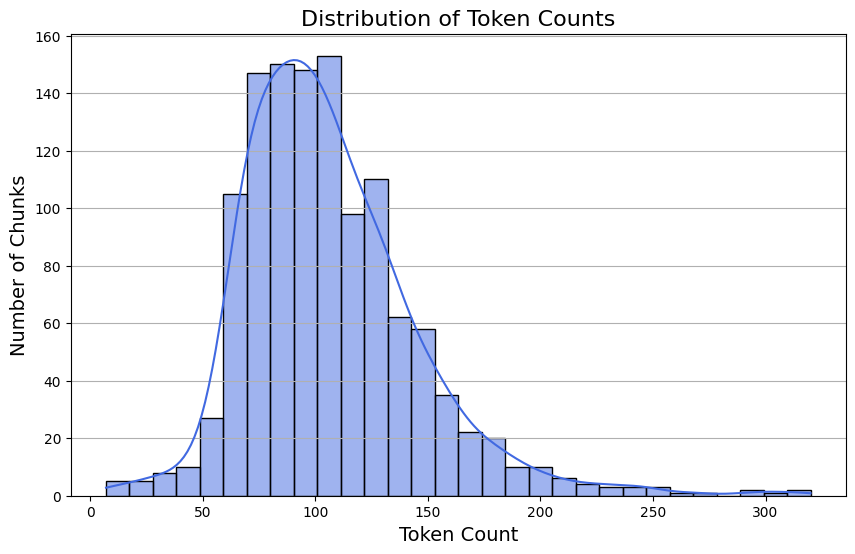

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df_enriched_docs['char_count'], bins=30, color='royalblue', kde=True)
plt.title('Distribution of Character Counts', fontsize=16)
plt.xlabel('Character Count', fontsize=14)
plt.ylabel('Number of Chunks', fontsize=14)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_enriched_docs['token_count'], bins=30, color='royalblue', kde=True)
plt.title('Distribution of Token Counts', fontsize=16)
plt.xlabel('Token Count', fontsize=14)
plt.ylabel('Number of Chunks', fontsize=14)
plt.grid(axis='y')
plt.show()

## Boxplot

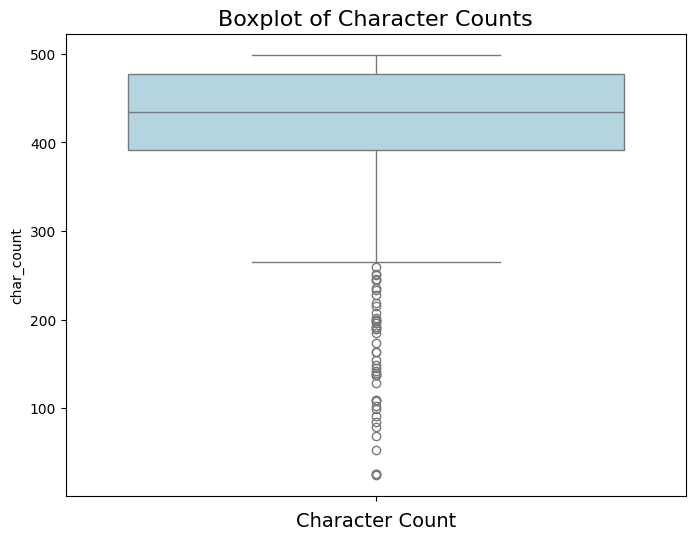

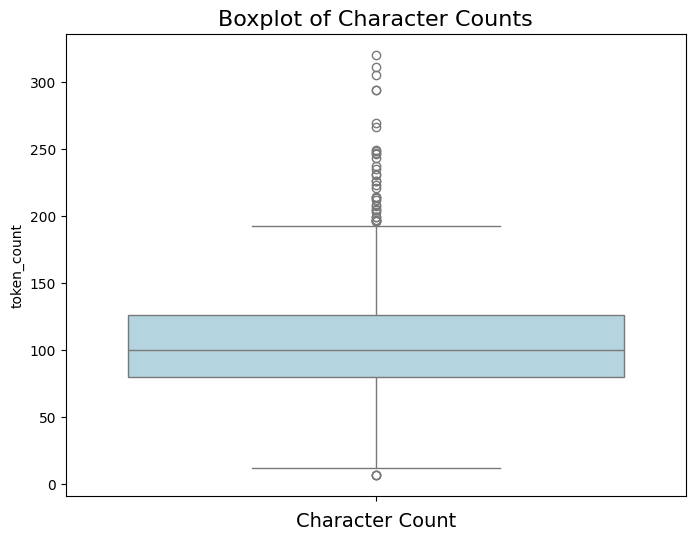

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(df_enriched_docs['char_count'], color='lightblue')
plt.title('Boxplot of Character Counts', fontsize=16)
plt.xlabel('Character Count', fontsize=14)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(df_enriched_docs['token_count'], color='lightblue')
plt.title('Boxplot of Character Counts', fontsize=16)
plt.xlabel('Character Count', fontsize=14)
plt.show()

## Test for normality

In [23]:
from scipy.stats import shapiro

stat, p = shapiro(df_enriched_docs['char_count'])

alpha = 0.05
if p > alpha:
    print(f"char_count looks normally distributed (p={p:.5f})")
else:
    print(f"char_count does not look normally distributed (p={p:.5f})")

char_count does not look normally distributed (p=0.00000)


In [24]:
from scipy.stats import shapiro

stat, p = shapiro(df_enriched_docs['token_count'])

alpha = 0.05
if p > alpha:
    print(f"token_count looks normally distributed (p={p:.5f})")
else:
    print(f"token_count does not look normally distributed (p={p:.5f})")

token_count does not look normally distributed (p=0.00000)


## Estimate Lambda for Poisson Distribution

The lambda (rate parameter) for a Poisson distribution is typically the mean of the observed data.



In [25]:
df= df_enriched_docs.copy()
lambda_estimate = df['token_count'].mean()

## Generate Expected Frequencies


We'll generate expected frequencies for our observed data using the estimated lambda.



In [26]:
from scipy.stats import poisson

# Generating observed frequencies
observed_freq = df['token_count'].value_counts().sort_index()

# Generating expected frequencies
expected_freq = poisson.pmf(observed_freq.index, lambda_estimate) * len(df)


# Changing the splitting strategy

In [88]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
new_text_splitter = SentenceTransformersTokenTextSplitter(tokens_per_chunk=384, chunk_overlap=0)
new_chunks = split_documents_into_chunks(directory_path, new_text_splitter)
new_df = enriched_docs_to_dataframe(new_chunks)

In [89]:
len(new_chunks)

720

## Plot Char Count / Token Count

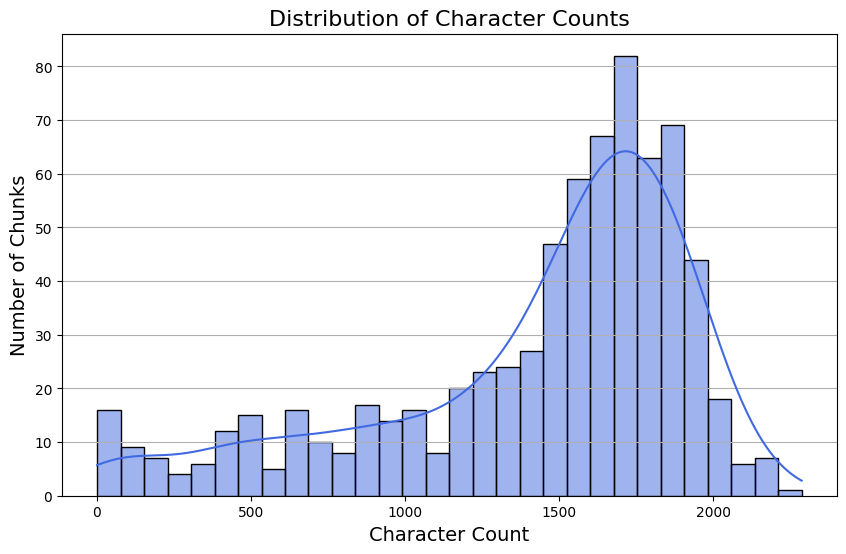

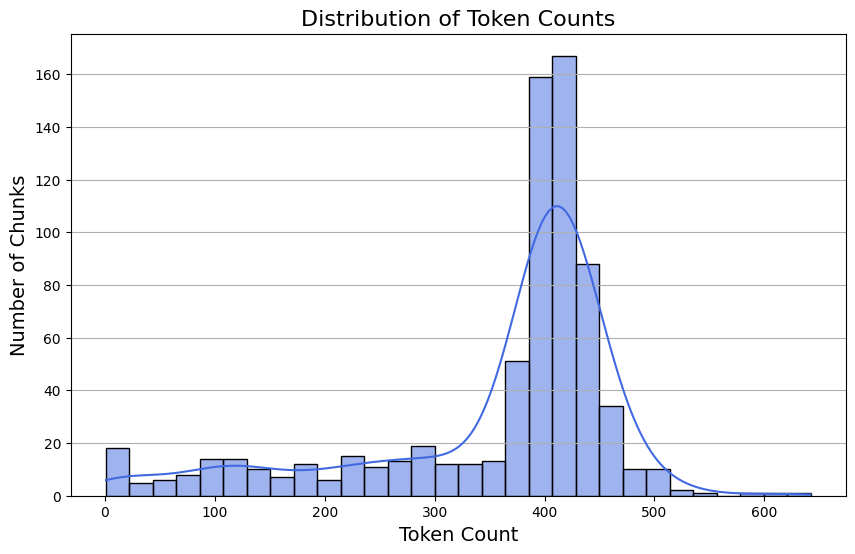

In [90]:
plt.figure(figsize=(10, 6))
sns.histplot(new_df['char_count'], bins=30, color='royalblue', kde=True)
plt.title('Distribution of Character Counts', fontsize=16)
plt.xlabel('Character Count', fontsize=14)
plt.ylabel('Number of Chunks', fontsize=14)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(new_df['token_count'], bins=30, color='royalblue', kde=True)
plt.title('Distribution of Token Counts', fontsize=16)
plt.xlabel('Token Count', fontsize=14)
plt.ylabel('Number of Chunks', fontsize=14)
plt.grid(axis='y')
plt.show()

## Compute embeddings

In [91]:
for chunk in new_chunks:
    chunk.page_content=preprocess_content(chunk.page_content)

In [92]:
import openai

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

## Compute Embeddings on all chunks

In [93]:
%%time

df=new_df.loc[:10,].copy()

df['ada_embedding'] = df['page_content'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
df.to_csv('output/embedded_chunks.csv', index=False)

CPU times: user 141 ms, sys: 72.4 ms, total: 213 ms
Wall time: 4.93 s


Super time-consuming, it would take 2 hours to compute the embeddings and store them -> we need to use other techniques

Using vectorstores or indexes

Vectorstores are tailor-made for this use case and we are better off using them to store the data

- Efficient Storage: These systems are optimized for storing large arrays of fixed-size vectors. They often use techniques like quantization to reduce the memory footprint of each vector, allowing for the storage of billions of vectors in memory.

- Fast Search: Vector stores implement Approximate Nearest Neighbor (ANN) algorithms, which trade off a small amount of accuracy for a significant increase in speed. This is particularly valuable when searching in high-dimensional spaces, such as embeddings produced by deep learning models.

- Batch Processing: Many of these libraries support batch processing, meaning they can search or insert multiple vectors at once, leveraging hardware and algorithmic optimizations for better throughput.

- Parallelism and GPU Acceleration: Libraries like FAISS can utilize multiple CPU cores or GPUs to speed up search and insertion operations. This parallel processing can significantly speed up operations, especially for large datasets.

- Scalability: Some vector stores can be distributed across multiple machines, allowing for horizontal scaling. This is crucial for applications that require storing or searching through very large datasets that don't fit into the memory of a single machine.

- Indexing Strategies: These systems offer a variety of indexing strategies tailored to different types of datasets and search requirements. This flexibility allows users to choose an indexing strategy that is best suited to their specific needs.

In [94]:
%%time

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS

embeddings=OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))
vectorstore=FAISS.from_documents(new_chunks, embeddings)

CPU times: user 688 ms, sys: 275 ms, total: 963 ms
Wall time: 11.6 s


In [95]:
def nearest_neighbors(query, k=6):
    results = vectorstore.similarity_search_with_score(query="climate", k=6)
    return results

query = "risks of climate change"
results = nearest_neighbors(query, k=6)

In [97]:
def prettify(results):
    global_output=""
    for result in results:
        output = f"Source: {result[0].metadata['source']}\n"
        output += f"Page: {result[0].metadata['page']}\n"
        output += f"Score: {result[1]}\n"
        output += f"Chunk ID: {result[0].metadata['chunk_id']}\n\n"
        output += "Content:\n"
        output += str({result[0].page_content})
        output += "\n"
        output += "=" * 80
        output += "\n"
        global_output += output
    return global_output

print(prettify(results))

Source: data/IPCC_AR6_WGI_TS.pdf
Page: 7
Score: 0.34252411127090454
Chunk ID: 21

Content:
{'short - lived climate forcers and their link to air quality ; and the ocean, cryosphere and sea level change. the last set of chapters ( chapters 10 – 12 and the atlas ) is dedicated to the assessment and distillation of regional climate information from multiple lines of evidence at sub - continental to local scales ( including urban climate ), with a focus on recent and projected regional changes in mean climate, extremes, and climatic impact - drivers. the new online'}
Source: data/IPCC_AR6_WGI_TS.pdf
Page: 33
Score: 0.3493475019931793
Chunk ID: 112

Content:
{'the current climate will change with warming, with warm extremes becoming more frequent ( virtually certain ), cold extremes becoming less frequent ( extremely likely ) and precipitation extremes becoming more frequent in most locations ( very likely ). { 9. 6. 4, 11. 2, 11. 3, 11. 4, 11. 6, 11. 7, 11. 8, 11. 9, box 9. 2 }'}
Source: d

# Prompt engineering

In [104]:
def system_prompt(results):
    prompt = "Hi there, climate chatbot! Provide an answer citing the SOURCE AND PAGE. If the answer is still not available, reply with your own knowledge."
    context = prettify(results)
    return prompt + "\n" + context

# Completion

In [105]:
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.chat_models import ChatOpenAI

def chatbot(query):
    chat = ChatOpenAI(model='gpt-4', temperature=0)
    messages = [
        SystemMessage(content=system_prompt(nearest_neighbors(query, k=5))),
        HumanMessage(content=query)
    ]
    return chat(messages).content


query = "Give me some  implications are expected from the combination of future urban development and more frequent occurrence of extreme climate events"
response = chatbot(query)


In [106]:
print(response)

Large implications are expected from the combination of future urban development and more frequent occurrence of extreme climate events, such as heatwaves, with more hot days and warm nights adding to heat stress in cities. Both sea levels and air temperatures are projected to rise in most coastal settlements. There is high confidence in an increase in pluvial flood potential in urban areas where extreme precipitation is projected to increase, especially at high global warming levels.

Source: IPCC AR6 WGI TS.pdf
Page: 111


# Push to Gradio

In [108]:
import gradio as gr

def model_function(input_text):
    return chatbot(input_text)

interface = gr.Interface(
    fn=model_function, 
    inputs="text", 
    outputs="text"
)

In [109]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7869
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Running on public URL: https://b9ae002d24600f8da0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
